In [2]:
%tensorflow_version 1.x

import tensorflow as tf
import os
import numpy as np
from IPython.display import display, Image
from tensorflow.python.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.models import Model

tf.enable_eager_execution()

TensorFlow 1.x selected.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
def load_and_process_image(img_path):
    img = preprocess_input(img_to_array(load_img(img_path)))
    img = np.expand_dims(img, axis = 0)
    return img

print(tf.__version__)

1.15.2


In [4]:
import matplotlib.pyplot as plt
def deprocess(x):
    # perform the inverse of the preprocessing step
    # these are imagenet means which it subtracted
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # BGR to RGB
    x = x[:, :, ::-1]
    # clipping if out of bounds
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis = 0)

    img = deprocess(img)
    # remove boundaries and axis
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

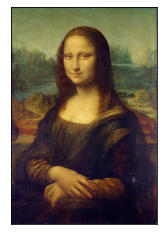

In [5]:
cdir = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer'
display_image(load_and_process_image(cdir + '/Mona_Lisa.jpg'))

In [6]:
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [7]:
# i skipped two layers as taken by author
# plz include b2 and b4 if you want
style_layers = [
    'block1_conv1', 
    'block3_conv1', 
    'block5_conv1'
]

content_layer = 'block5_conv2'

# intermediate models
content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input, 
                      outputs = model.get_layer(layer).output) for layer in style_layers]


In [8]:
# Content Cost
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    # simple mse
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

# references taken from: google colab learning notes
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)


In [9]:
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
    
    return J_style

In [10]:

import time

generated_images = []

def training_loop(content_path, style_path, iterations = 20, a = 10., b = 20.):
    # initialise
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate = 7.)
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image




In [11]:
final = training_loop(cdir + '/Mona_Lisa.jpg', cdir + '/Shraddha_Kapoor.jpg')

Cost at 0: 1120789760.0. Time elapsed: 67.42560863494873
Cost at 2: 607045312.0. Time elapsed: 194.92213129997253
Cost at 4: 433835360.0. Time elapsed: 322.81339383125305
Cost at 6: 333685536.0. Time elapsed: 450.27143454551697
Cost at 8: 265593168.0. Time elapsed: 578.7334334850311
Cost at 10: 217457136.0. Time elapsed: 708.8030166625977
Cost at 12: 182397408.0. Time elapsed: 837.9476447105408
Cost at 14: 154911392.0. Time elapsed: 964.7212686538696
Cost at 16: 132874832.0. Time elapsed: 1091.4065718650818
Cost at 18: 115109920.0. Time elapsed: 1218.2828876972198


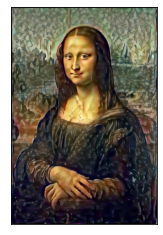

In [12]:
display_image(final)

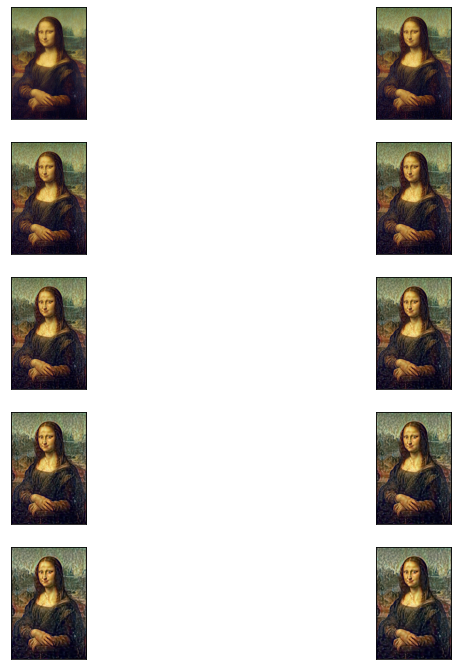

In [13]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()

generated_images = []

In [14]:
final_revert = training_loop(cdir + '/Shraddha_Kapoor.jpg', cdir + '/Mona_Lisa.jpg', iterations=30)

Cost at 0: 1120789760.0. Time elapsed: 71.23310232162476
Cost at 3: 340106528.0. Time elapsed: 284.04296612739563
Cost at 6: 197575648.0. Time elapsed: 498.2495086193085
Cost at 9: 132870600.0. Time elapsed: 710.4560647010803
Cost at 12: 94071536.0. Time elapsed: 922.818799495697
Cost at 15: 70050600.0. Time elapsed: 1137.461618423462
Cost at 18: 53262852.0. Time elapsed: 1350.0579998493195
Cost at 21: 41718296.0. Time elapsed: 1562.8153717517853
Cost at 24: 33854152.0. Time elapsed: 1776.651354789734
Cost at 27: 28083582.0. Time elapsed: 1989.2193908691406


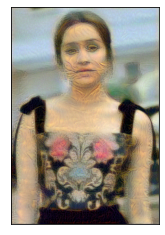

In [15]:
display_image(final_revert)

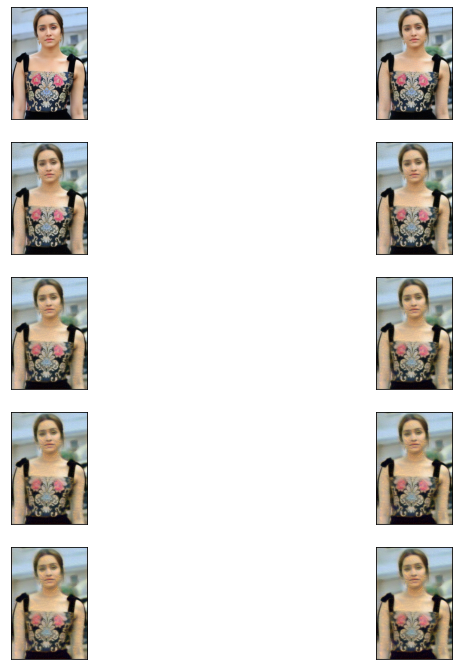

In [16]:
plt.figure(figsize = (12, 12))

for i in range(10):
    plt.subplot(5, 2, i + 1)
    display_image(generated_images[i])
plt.show()

generated_images = []